In [1]:
import math
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from gudhi import SimplexTree
from tqdm.notebook import tqdm

# Some Cube tesselations generating functions

In [2]:
def cube_simplex_generator(dimension):
    # Generates (dimension+1)-simplices, which are from dimension-cube triangulation
    if dimension == 2:
        yield [np.array([0, 0]), 
               np.array([0, 1]), 
               np.array([1, 0])]
        yield [np.array([0, 1]), 
               np.array([1, 0]), 
               np.array([1, 1])]
    else:
        pass

In [3]:
def get_simplicies(matrix):
    # 
    dimension = len(matrix.shape)
    n = np.array(matrix.shape, dtype=int)
    coefs = np.zeros(dimension, dtype=int)
    for i in range(dimension):
        coefs[i] = n[:i].prod()
    
    cords = np.array(np.where(matrix)).transpose()
    simplicies = []
    for cord in cords:
        for vector in cube_simplex_generator(dimension):
            simplicies.append((cord + vector)%n)
    for i in range(len(simplicies)):
        simplicies[i] = (simplicies[i] * coefs).sum(axis=1)
    return simplicies

In [4]:
def get_torus_with_filtration(matrix):
    # 
    st = SimplexTree()
    ps = np.unique(np.concatenate([[0, 1], matrix.reshape(np.prod(matrix.shape))]))
    for p in ps:
        for simplex in get_simplicies(matrix == p):
            st.insert(simplex, filtration=p)
    return st

# Generating torus with cubical tesselation filtration

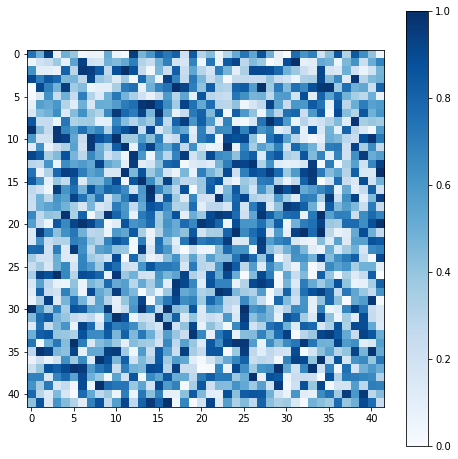

In [5]:
n = 42
matrix = np.random.random([n, n])

plt.figure(figsize=(8, 8))
pixel_plot = plt.imshow(matrix , cmap='Blues', vmin=0, vmax=1)
plt.colorbar(pixel_plot)
plt.show()

In [6]:
ps = np.append(np.arange(0, 1, 0.033), 1)

st = get_torus_with_filtration(matrix)
st.set_dimension(3)
st.compute_persistence()

/tmp/ipykernel_122068/3046788032.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


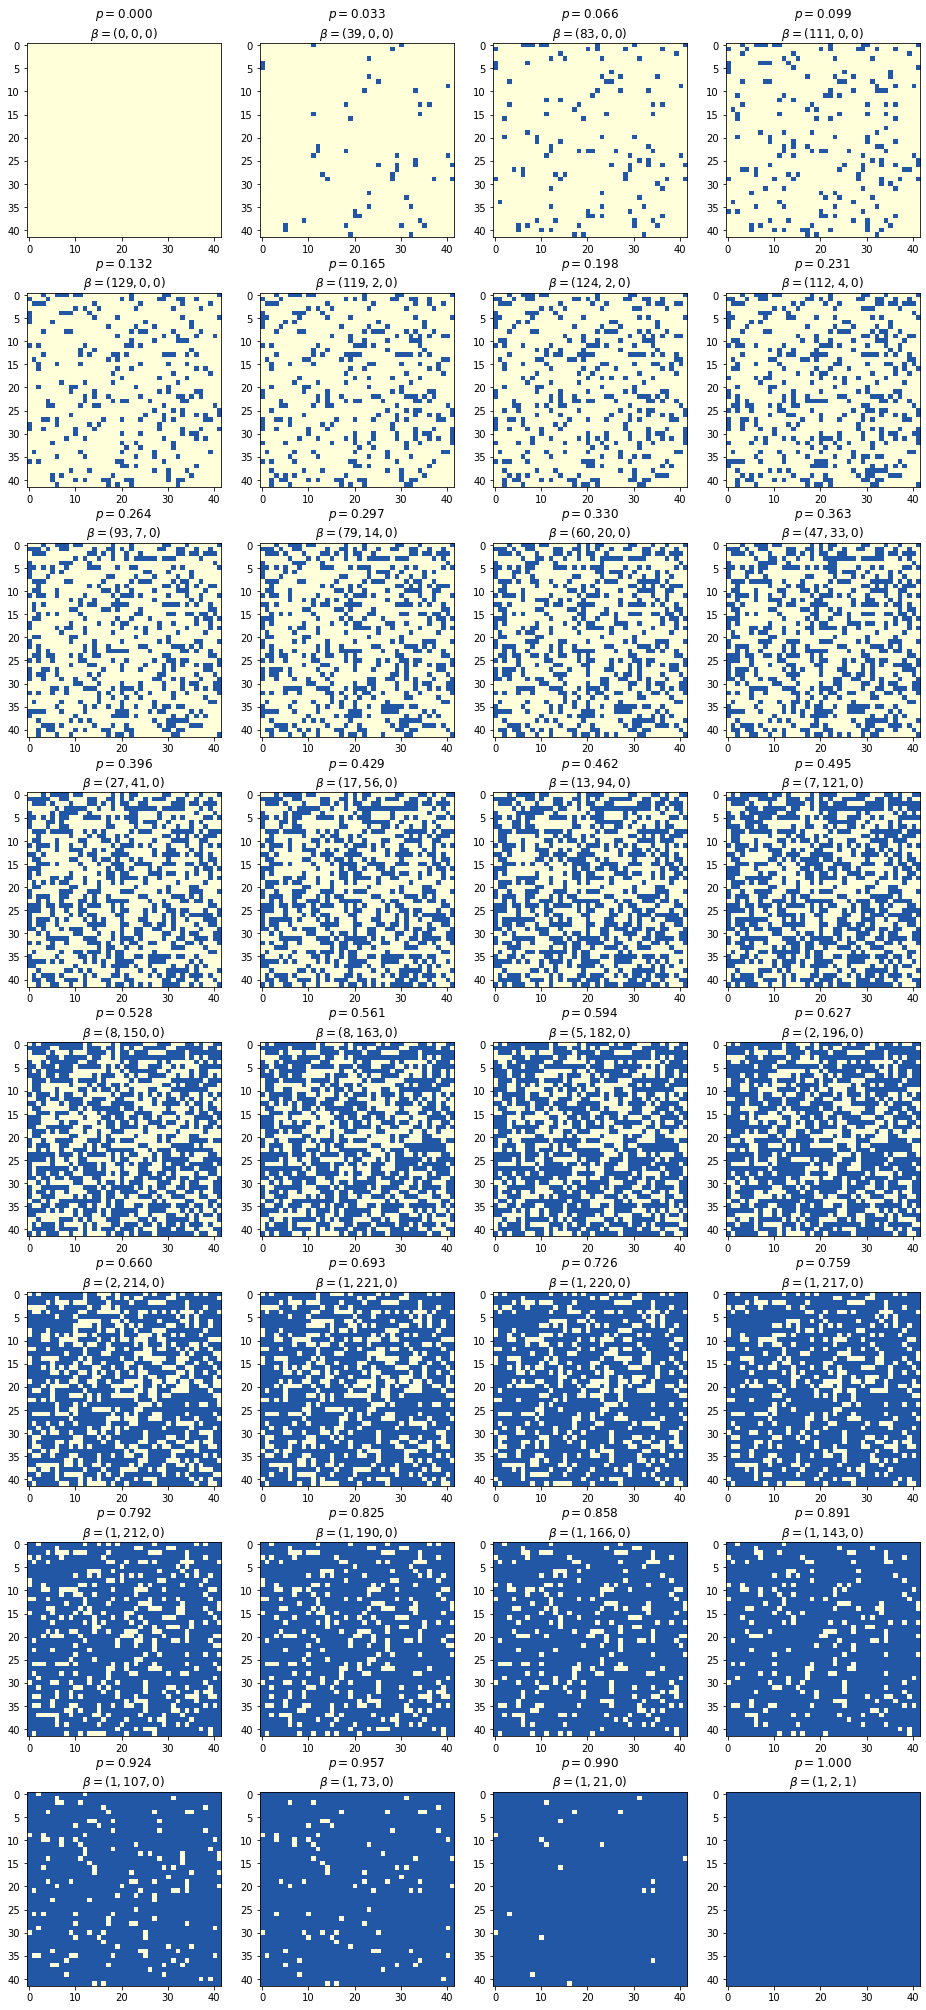

In [7]:
fig, axs = plt.subplots((len(ps)+3)//4, 4, figsize=(16, (len(ps)+3)//4*4 + 4))

for i in range(len(ps)):
    p = ps[i]
    b = st.persistent_betti_numbers(p, p)
    message = '$p = {0: .3f}$\n$\\beta = {1}$'.format(p, b).replace('[', '(').replace(']', ')')
    axs[i//4, i%4].set_title(message)
    axs[i//4, i%4].imshow(matrix <= p, cmap='YlGnBu', vmin=0, vmax=1.3)
fig.show()

# Analyze betti-numbers

In [8]:
ps = np.concatenate([[0], np.unique(matrix), [1]])
b0 = []
b1 = []
for p in ps:
    b = st.persistent_betti_numbers(p, p)
    if b == []:
        b = (0, 0)
    b0.append(b[0])
    b1.append(b[1])  

max(b_0) = 133
max(b_1) = 228 

Intersections of b0 and b1:
b_0(0.00) = b_1(0.00) = 0
b_0(0.38) = b_1(0.38) = 34


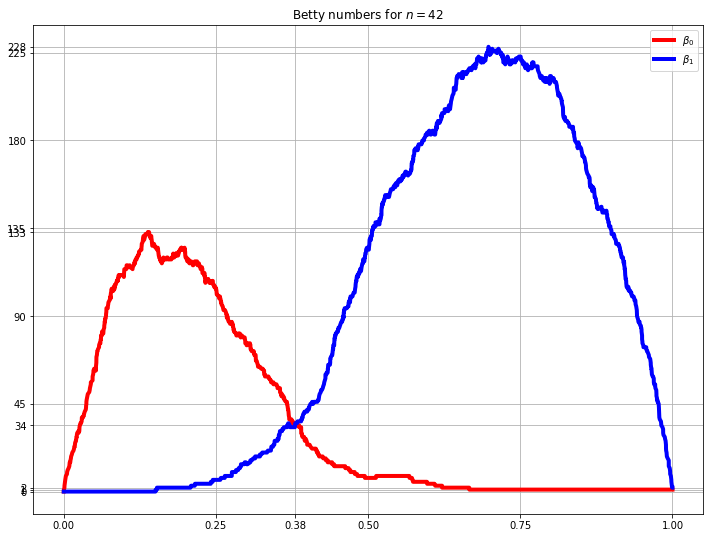

In [9]:
b0_max = max(b0)
b1_max = max(b1)
p_cross = []
b_cross = []
for i in range(len(ps)):
    if b0[i] == b1[i]:
        p_cross.append(ps[i])
        b_cross.append(b0[i])
print('max(b_0) =', b0_max)
print('max(b_1) =', b1_max, '\n')
print('Intersections of b0 and b1:')
for i in range(len(p_cross)):
    print('b_0({0:1.2f}) = b_1({0:1.2f}) = {1}'.format(p_cross[i], b_cross[i]))


yticks = np.unique(np.concatenate([np.arange(3), b_cross, [b0_max, b1_max], 
                                   np.arange(0, max(b0_max, b1_max), max(b0_max, b1_max)//5)]))
#xticks = np.unique(np.concatenate([ps[np.arange(0, len(ps), len(ps)//4)], [0, 1], p_cross]))
xticks = np.unique(np.concatenate([np.arange(0, 1, 0.25), [1], p_cross]))

plt.figure(figsize=(12, 9))
plt.title('Betty numbers for $n = {0}$'.format(n))
plt.plot(ps, b0, color='red', linewidth=4, label='$\\beta_0$')
plt.plot(ps, b1, color='blue', linewidth=4, label='$\\beta_1$')
plt.legend()
plt.xticks(xticks)
plt.yticks(yticks)
plt.grid(True)
plt.show()

In [10]:
filtration_values = np.unique([i[1] for i in st.get_filtration()])
filtration_values

array([2.39471354e-04, 1.09373240e-03, 1.20600393e-03, ...,
       9.99039390e-01, 9.99362773e-01, 9.99905374e-01])

# Checking cycle births

In [11]:
def get_filtration_values(st: SimplexTree):
    # 
    filtration_values = np.unique([i[1] for i in st.get_filtration()])
    start_value = int(filtration_values.min())
    if start_value == filtration_values.min():
        start_value -= 1
    filtration_values = np.append(start_value, filtration_values)
    return filtration_values

In [12]:
def get_changing_values(st: SimplexTree):
    # 
    filtration_values = get_filtration_values(st)
    changing_values = [filtration_values[0]]
    for value in filtration_values:
        if st.persistent_betti_numbers(value, value) != st.persistent_betti_numbers(changing_values[-1], changing_values[-1]):
            changing_values.append(value)
    return np.array(changing_values)

In [13]:
changing_values = get_changing_values(st)
pd.DataFrame([{'Vertex': i, 
               'Value': changing_values[i], 
               'Betty': st.persistent_betti_numbers(changing_values[i], 
                                                           changing_values[i])} for i in range(len(changing_values))])

,Vertex,Value,Betty
0,0,0.000000,"[0, 0, 0]"
1,1,0.000239,"[1, 0, 0]"
2,2,0.001094,"[2, 0, 0]"
3,3,0.001206,"[3, 0, 0]"
4,4,0.001611,"[4, 0, 0]"
...,...,...,...
1003,1003,0.998203,"[1, 5, 0]"
1004,1004,0.998601,"[1, 4, 0]"
1005,1005,0.999039,"[1, 3, 0]"
1006,1006,0.999363,"[1, 2, 0]"


In [14]:
def get_simplex_groups(st: SimplexTree):
    # 
    groups = {}
    changing_values = get_changing_values(st)
    simplicies, filtration = np.array([i for i in st.get_filtration()]).transpose()
    for i in range(1, len(changing_values)):
        p0 = changing_values[i-1]
        p1 = changing_values[i]
        groups.update({p1 : list(simplicies[np.logical_and(filtration > p0, filtration <= p1)])})
    return groups

In [15]:
def get_cell_groups(sr: SimplexTree, matrix):
    # 
    groups = {}
    changing_values = get_changing_values(st)
    for i in range(1, len(changing_values)):
        p0 = changing_values[i-1]
        p1 = changing_values[i]
        groups.update({p1 : np.where(np.logical_and(matrix > p0, matrix <= p1))})
    return groups

There are 1007 groups.
Avarege group length is 0.51.


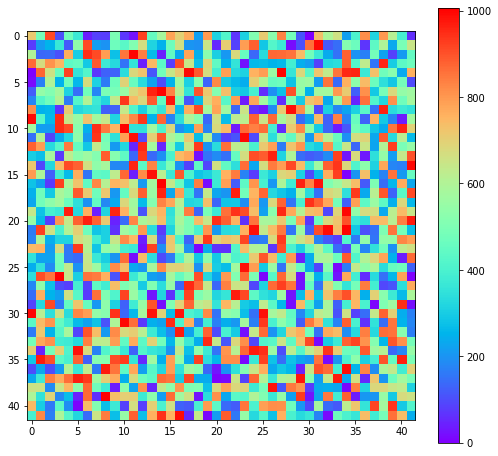

In [16]:
group_matrix = np.zeros(matrix.shape)
cell_groups = get_cell_groups(st, matrix)
keys = np.array(list(cell_groups.keys()))
for key in keys:
    group_matrix[cell_groups[key]] = np.where(keys == key)[0]

print('There are', len(cell_groups), 'groups.')
print('Avarege group length is {0:.2f}.'.format(np.mean(keys)))

plt.figure(figsize=(8, 8))
vmax = np.max(group_matrix)
pixel_plot = plt.imshow(group_matrix , cmap='rainbow', vmin=0, vmax=vmax)
#ticks = np.unique(np.concatenate([np.arange(0, vmax, vmax//12), [0, vmax]]))
plt.colorbar(pixel_plot, fraction=0.08)#, ticks=ticks)
plt.show()

In [17]:
def get_simplex_filtration_dict(st: SimplexTree):
    # returns dict, which keys are simplicies (tuples), and values are filtration values (floats)
    simplex_filtration = {}
    for i in st.get_filtration():
        simplex_filtration.update({tuple(i[0]) : i[1]})
    return simplex_filtration

In [18]:
def get_cycle_info(st: SimplexTree):
    # 
    info = pd.DataFrame(columns=['Birth', 'Death', 'Dimension'])
    changing_values = get_changing_values(st)
    epsilon = 0.25*(changing_values[1:] - changing_values[:-1]).min()
    simplex_filtration_dict = get_simplex_filtration_dict(st)
    
    for birth_simplex, death_simplex in st.persistence_pairs():
        birth = simplex_filtration_dict[tuple(np.sort(birth_simplex))]
        try: 
            death = simplex_filtration_dict[tuple(np.sort(death_simplex))]
        except KeyError:
            death = np.inf
        birth_betty_difference = np.array(st.persistent_betti_numbers(birth, birth)) - np.array(st.persistent_betti_numbers(birth - epsilon, birth - epsilon))
        death_betty_difference = np.array(st.persistent_betti_numbers(death, death)) - np.array(st.persistent_betti_numbers(death - epsilon, death - epsilon))
        if (birth_betty_difference != 0).sum() == 1:
            dimension = np.where(birth_betty_difference != 0)[0][0]
        else:
            dimension = np.where(birth_betty_difference != 0)[0][0]
        
        info = info.append({'Birth' : birth,  
                            'Death' : death, 
                            'Dimension' : dimension, 
                            'Birth Betty Difference' : birth_betty_difference, 
                            'Death Betty Difference' : death_betty_difference, 
                           }, ignore_index=True)
    return pd.DataFrame(info)

In [19]:
def get_cycle_info(st: SimplexTree):
    # 
    info = pd.DataFrame(columns=['Birth', 'Death', 'Dimension'])
    
    changing_values = get_changing_values(st)
    eps = 0.5*(changing_values[1:] - changing_values[:-1]).min()
    simplex_filtration_dict = get_simplex_filtration_dict(st)
    
    for birth_simplex, death_simplex in st.persistence_pairs():
        birth = simplex_filtration_dict[tuple(np.sort(birth_simplex))]
        try: 
            death = simplex_filtration_dict[tuple(np.sort(death_simplex))]
        except KeyError:
            death = np.inf
            
        born = np.array(st.persistent_betti_numbers(birth + eps, -np.inf)) - np.array(st.persistent_betti_numbers(birth - eps, -np.inf))
        if (born != 0).sum() == 1:
            dimension = np.where(born != 0)[0][0]
        else:
            message = 'Я просто не придумал, что в этом случае делать. Но он маловероятен.'
            message += '\nОднако когда-то всё-таки случится. C чем я тебя и поздравляю!\n\n'
            message += 'А вообще, суть в том, что в один момент родилось несколько циклов разной размерности.'
            raise ValueError(message)
        
        info = pd.concat([info, pd.DataFrame([{'Birth' : birth,  
                                               'Death' : death, 
                                               'Dimension' : dimension
                                             }])], ignore_index=True)
    info = info.astype({'Birth': float, 'Death': float, 'Dimension': int})
    return pd.DataFrame(info)

In [20]:
cycle_info = get_cycle_info(st)
cycle_info[cycle_info['Death'] == np.inf]

,Birth,Death,Dimension
535,0.000239,inf,0
536,0.391626,inf,1
537,0.429878,inf,1
538,0.999905,inf,2


In [21]:
giant_cycles = cycle_info[(cycle_info['Death'] == np.inf) & (cycle_info['Dimension'] == 1)]['Birth'].values
giant_cycles

array([0.39162603, 0.42987757])

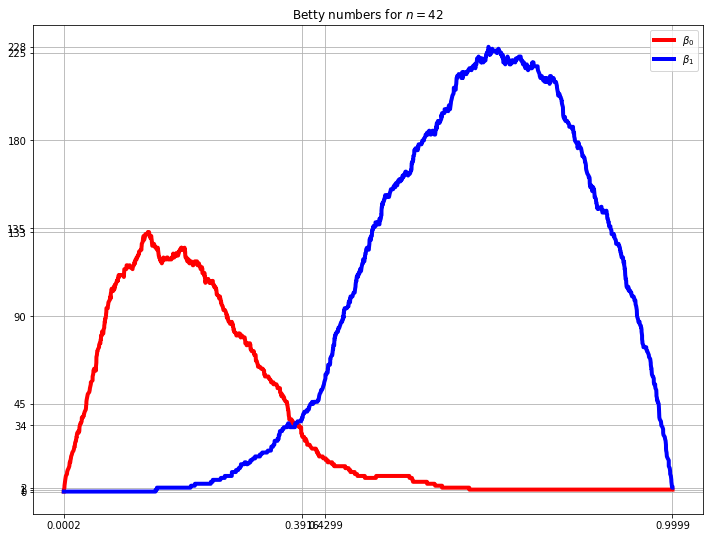

In [22]:
yticks = np.unique(np.concatenate([np.arange(3), b_cross, [b0_max, b1_max], 
                                   np.arange(0, max(b0_max, b1_max), max(b0_max, b1_max)//5)]))
xticks = cycle_info[cycle_info['Death'] == np.inf]['Birth'].values

plt.figure(figsize=(12, 9))
plt.title('Betty numbers for $n = {0}$'.format(n))
plt.plot(ps, b0, color='red', linewidth=4, label='$\\beta_0$')
plt.plot(ps, b1, color='blue', linewidth=4, label='$\\beta_1$')
plt.legend()
plt.xticks(xticks)
plt.yticks(yticks)
plt.grid(True)
plt.show()

## Euler Char

In [23]:
def persistence_euler_char(st: SimplexTree, p):
    betti = np.array(st.persistent_betti_numbers(p, p))
    betti[np.arange(len(betti)) % 2 == 1] *= -1
    return betti.sum()

In [24]:
def expired_ec(n, p, d=2):
    s0 = 0
    for k in range(d+1):
        s1 = 0
        for j in range(d+2-k):
            s1 += (-1)**(d+1-k-j) * math.comb(d-k, j) * j**(d+1)
        ds0 = n * (-1)**k * (1 - (1-p)**(d+1-k)) * s1
        s0 += ds0
    return s0

In [29]:
def expected_ec(n, p, d=2):
    s = 0
    for k in range(d+1):
        s += (-1)**k * math.comb(d, k) * (1 - (1 - p)**(2**(d-k)))
    #s *= n**2 # В статье просто на n оно умножалось.
    s *= n*n
    return s

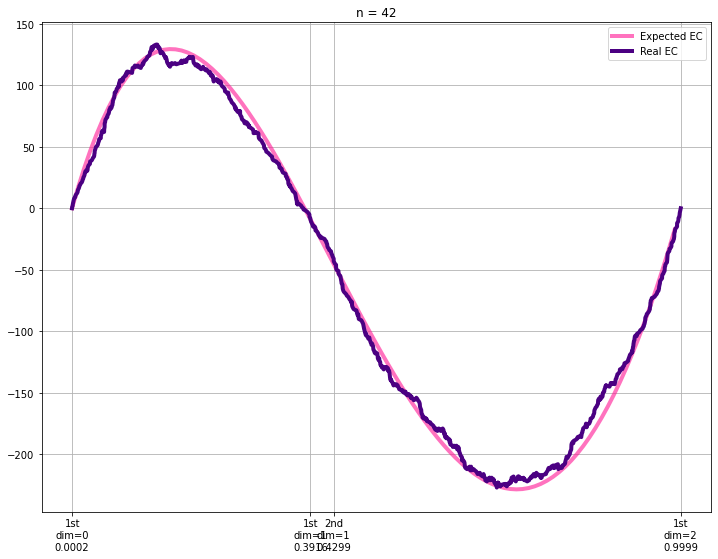

In [30]:
xticks = cycle_info[cycle_info['Death'] == np.inf]['Birth'].values
xlabels = np.array(['1st\ndim=0', '1st\ndim=1', '2nd\ndim=1', '1st\ndim=2'])
xlabels = np.char.add(xlabels, '\n')
xlabels = np.char.add(xlabels, np.round(xticks, 4).astype(str))

plt.figure(figsize=(12, 9))
plt.title('n = {}'.format(n))

x = np.arange(0, 1, 0.01)
y = [expired_ec(n, p) for p in x]
y = [expected_ec(n, p) for p in x]
plt.plot(x, y, color='deeppink', linewidth=4, alpha=0.6, label='Expected EC')

x = changing_values
y = np.array([persistence_euler_char(st, p) for p in x])
plt.plot(x, y, color='indigo', linewidth=4, label='Real EC')


plt.xticks(xticks, xlabels)
plt.grid(True)
plt.legend()
plt.show()

# Expirement about time of birth the first and the second giant cycle

In [27]:
N = 100
shape = 12, 12

In [28]:
matricies = np.random.random(size=(N, shape[0], shape[1]))

sts = [get_torus_with_filtration(m) for m in matricies]
for i in range(N):
    sts[i].compute_persistence()

cycle_infos = [get_cycle_info(i) for i in sts]
giant_births = np.array([df[(df['Death'] == np.inf)&(df['Dimension'] == 1)]['Birth'].values for df in cycle_infos])

In [29]:
mean1, mean2 = giant_births.mean(axis=0)
var1, var2 = giant_births.var(axis=0)

message0 = 'The number of expirience is {0} and the matrix size is {1}.'.format(N, shape)
message1 = 'The first  giant cycle birth mean is {0:.4f} with variance {1:.4f}'.format(mean1, var1)
message2 = 'The second giant cycle birth mean is {0:.4f} with variance {1:.4f}'.format(mean2, var2)

print(message0)
print(message1)
print(message2)

The number of expirience is 100 and the matrix size is (12, 12).
The first  giant cycle birth mean is 0.3841 with variance 0.0042
The second giant cycle birth mean is 0.4489 with variance 0.0033


## Dependness from size

### Practical dependence

In [30]:
N = 10
ns = np.arange(3, 13)
ns

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [31]:
means = []

for n in tqdm(ns):
    matricies = np.random.random(size=(N, n, n))
    cycle_infos = []
    giant_births = []
    for i in tqdm(range(N)):
        sti = get_torus_with_filtration(matricies[i])
        sti.compute_persistence()
        cycle_infos.append(get_cycle_info(sti))
        df = cycle_infos[i]
        giant_births.append(df[(df['Death'] == np.inf)&(df['Dimension'] == 1)]['Birth'].values)
    giant_births = np.array(giant_births)
    means.append(giant_births.mean(axis=0))

means = np.array(means).transpose()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

### Theoretical dependence

In [32]:
functions = [lambda x: expected_ec(n=n, p=x, d=2) for n in ns]
[f(0.6) for f in functions]

[-15.206399999999988,
 -15.206399999999988,
 -15.206399999999988,
 -15.206399999999988,
 -15.206399999999988,
 -15.206399999999988,
 -15.206399999999988,
 -15.206399999999988,
 -15.206399999999988,
 -15.206399999999988]

### Visualize

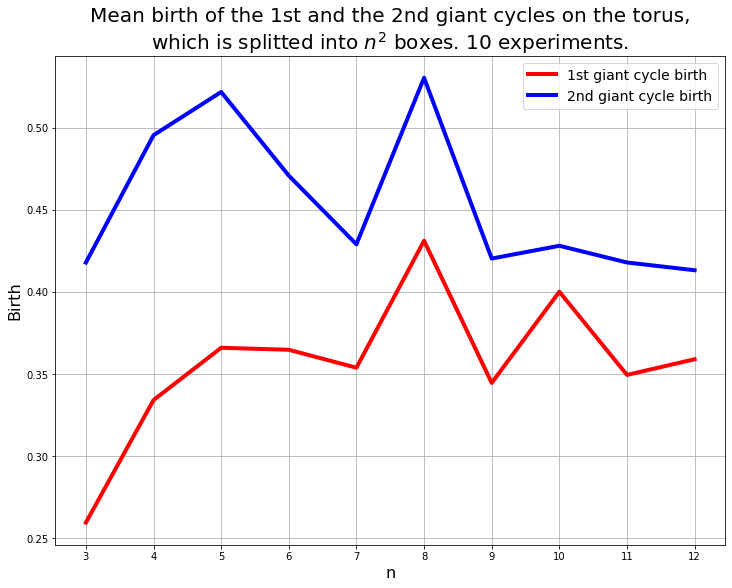

In [33]:
plt.figure(figsize=(12, 9))

title = 'Mean birth of the 1st and the 2nd giant cycles on the torus,\nwhich is splitted into $n^2$ boxes. {} experiments.'.format(N)

plt.title(title, fontsize=20)
plt.plot(np.arange(len(ns)), means[0], color='red',  linewidth=4, label='1st giant cycle birth')
plt.plot(np.arange(len(ns)), means[1], color='blue', linewidth=4, label='2nd giant cycle birth')
plt.legend(fontsize=14)

xticks, xlabels = np.arange(len(ns)), ns
choose = np.unique(np.append(np.arange(0, len(ns), len(ns)//8), len(ns)-1))
plt.xticks(xticks[choose], xlabels[choose])
plt.xlabel('n', fontsize=16)
plt.ylabel('Birth', fontsize=16)
plt.grid(True)
plt.show()